# Measure Biofilm Volumina
## Structure
1. [Imports](#imports)
2. [Crosstalk](#crosstalk)
3. [Test algorithm on sinlge file](#single-file)
4. [Run algorithm on all files](#algorithm)

## Imports
[back to table of contents](#structure)

In [1]:
# Filenames, paths, regular expressions & enums
import os
import json
from pathlib import Path
# Type hints
from typing import List, Tuple
# Math & tables
import numpy as np
import pandas as pd
# Handling, plotting and proccesiing images
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
from skimage import filters, morphology
from scipy.optimize import curve_fit
from dataclasses import dataclass, field

from toolbox.image import load_image, get_fluors, get_voxel_sizes, get_hours_post_infection, get_sample_number, get_crosstalk_fluor
from toolbox.crosstalk import calculate_crosstalk, correct_crosstalk
from toolbox.utility import fluors_to_color, get_all_tiffs_in, get_germs, get_germs_new
from toolbox.analysis import median_filter, calculate_volume, make_rois
from toolbox.thresholding import compose, blur, auto_li_thresholding, manual_thresholding, threshold
from toolbox.data import Biofilm, Crosstalk
from toolbox.paths import IMAGE_FOLDER, CROSSTALK_FOLDER, RESULT_FOLDER

## Crosstalk
[back to table of contents](#structure)

In [2]:
path = RESULT_FOLDER.joinpath('Crosstalk.json')
if path.exists():
    crosstalk_df = pd.read_json(path)
else:
    crosstalks = []
    crosstalk_tiffs = get_all_tiffs_in(CROSSTALK_FOLDER)
    for file in crosstalk_tiffs:
        path = CROSSTALK_FOLDER / file
        germ = get_germs(file)[0]
        fluors = get_fluors(path)
        crosstalk_img = load_image(path)
        main_channel, main_fluor = get_crosstalk_fluor(path)
        if file == 'S. aureus SH1000 Cyan 24h Crosstalk.tif':
            crosstalk = calculate_crosstalk(crosstalk_img[[0, 2, 1]], main_channel)
        else:
                crosstalk = calculate_crosstalk(crosstalk_img, main_channel)
        crosstalks.append(Crosstalk(file=file, germ=germ, fluors=fluors, main_channel=main_channel, main_fluor=main_fluor, crosstalk=crosstalk))
    del crosstalk_img
    crosstalk_df = pd.DataFrame.from_dict(crosstalk.to_dict() for crosstalk in crosstalks)
    crosstalk_df.to_json(os.path.join(RESULT_FOLDER, 'Crosstalk.json'))

crosstalk_df

,file,germ,channel,fluor,green,red,blue
0,C. albicans sfGFP 24h Crosstalk.tif,albicans,0,GFP,0.000000,0.035004,0.005001
1,K279a GFP Crosstalk.tif,k279a,1,GFP,0.000000,0.035004,0.035004
2,P. aeruginosa PA01 eYFP Crosstalk.tif,pa01,2,eYFP,0.024994,0.005001,0.000000
3,P. aeruginosa PAO1 mCherry Crosstalk.tif,pao1,1,mCherry,0.085022,0.000000,0.024994
4,PAO1 sf GFP 24h Crosstalk.tif,pao1,1,GFP,0.000000,0.005001,0.044983
5,S. aureus SH1000 Cyan 24h Crosstalk.tif,aureus,2,Cyan,0.085022,0.005001,0.000000
6,S. aureus SH1000 mCherry Crosstalk.tif,aureus,1,mCherry,0.014999,0.000000,0.005001


## Algorithm
[back to table of contents](#structure)

In [3]:
files = get_all_tiffs_in(IMAGE_FOLDER)

In [4]:
with open(RESULT_FOLDER / "manuaL_thresholds.json") as f:
    manual_thresholds = json.load(f)
manual_thresholds

{'K279a td tomato + S. aureus SH 1000 Cyan + P. aeruginosa PAO1 sf GFP 24h 4.tif': {'2': 0.045},
 'K279a td tomato + S. aureus SH 1000 Cyan + P. aeruginosa PAO1 sf GFP 24h 5.tif': {'2': 0.045},
 'K279a td tomato + S. aureus SH 1000 Cyan + P. aeruginosa PAO1 sf GFP 24h 6.tif': {'2': 0.045},
 'K279a td tomato + S. aureus SH 1000 Cyan + P. aeruginosa PAO1 sf GFP 48h 1.tif': {'2': 0.1},
 'K279a td tomato + S. aureus SH 1000 Cyan + P. aeruginosa PAO1 sf GFP 48h 2.tif': {'2': 0.045},
 'K279a td tomato + S. aureus SH 1000 Cyan + P. aeruginosa PAO1 sf GFP 48h 3.tif': {'2': 0.06},
 'K279a td tomato + S. aureus SH 1000 Cyan + P. aeruginosa PAO1 sf GFP 72h 1.tif': {'2': 0.16},
 'K279a td tomato + S. aureus SH 1000 Cyan + P. aeruginosa PAO1 sf GFP 72h 2.tif': {'2': 0.155},
 'K279a td tomato + S. aureus SH 1000 Cyan + P. aeruginosa PAO1 sf GFP 72h 3.tif': {'2': 0.155},
 'K279a td tomato + P. aeruginosa PAO1 GFP 24h 3.tif': {'1': 0.015,
  '0': 0.015},
 'K279a td tomato + P. aeruginosa PAO1 GFP 24h 2

In [5]:
biofilms = []
for file in files:
    path = IMAGE_FOLDER / file
    print(path)
    fluors = get_fluors(path)
    colors = [fluors_to_color[fluor] for fluor in fluors]
    voxel_sizes = get_voxel_sizes(path)
    time = get_hours_post_infection(file)
    sample = get_sample_number(file)
    germs, germs_ = get_germs_new(file, colors)
    name = ' + '.join(germs_)
    img = load_image(path)
    img = correct_crosstalk(img=img, germs=germs, colors=colors, crosstalk=crosstalk_df)
    voxel_volume = np.prod(voxel_sizes)
    thresholds = []
    slice_volumes = {}
    total_volumes = []

    for c, channel in enumerate(img):
        blurred = blur(sigma=2)(channel)
        if (file in manual_thresholds) and (str(c) in manual_thresholds[file]):
            thresholded = threshold(manual_thresholding(threshold=manual_thresholds[file][str(c)], min_size=32))(blurred)
        else:
            thresholded = threshold(auto_li_thresholding(min_size=32, f_thr=2.0))(blurred)
        slice_volumes[c] = [slice.sum() * voxel_volume for slice in thresholded]
        total_volumes.append(np.sum(slice_volumes[c]))

    
    biofilm = Biofilm(name=name,
        image_shape=img.shape,
        growth_duration=time,
        sample=sample,
        voxel_sizes=voxel_sizes,
        fluors=fluors,
        colors=colors,
        germs=germs,
        total_volumes=total_volumes,
        slice_volumes=slice_volumes)
    biofilms.append(biofilm)

D:\a_Projects\Ifey_Alio_\Data\TIFF\C. albicans sfGFP 24h 1.tif
D:\a_Projects\Ifey_Alio_\Data\TIFF\C. albicans sfGFP 24h 4.tif
D:\a_Projects\Ifey_Alio_\Data\TIFF\C. albicans sfGFP 24h 5.tif
D:\a_Projects\Ifey_Alio_\Data\TIFF\C. albicans sfGFP 48h 4.tif
D:\a_Projects\Ifey_Alio_\Data\TIFF\C. albicans sfGFP 48h 5.tif
D:\a_Projects\Ifey_Alio_\Data\TIFF\C. albicans sfGFP 48h 6.tif
D:\a_Projects\Ifey_Alio_\Data\TIFF\C. albicans sfGFP 72h 4.tif
D:\a_Projects\Ifey_Alio_\Data\TIFF\C. albicans sfGFP 72h 5.tif
D:\a_Projects\Ifey_Alio_\Data\TIFF\C. albicans sfGFP 72h 6.tif
D:\a_Projects\Ifey_Alio_\Data\TIFF\K279a GFP + S. aureus SH 1000 mCherry 24h 1.tif
D:\a_Projects\Ifey_Alio_\Data\TIFF\K279a GFP + S. aureus SH 1000 mCherry 24h 2.tif
D:\a_Projects\Ifey_Alio_\Data\TIFF\K279a GFP + S. aureus SH 1000 mCherry 24h 3.tif
D:\a_Projects\Ifey_Alio_\Data\TIFF\K279a GFP + S. aureus SH 1000 mCherry 48h 1.tif
D:\a_Projects\Ifey_Alio_\Data\TIFF\K279a GFP + S. aureus SH 1000 mCherry 48h 2.tif
D:\a_Projects\Ifey

In [6]:
slice_data = {}
for biofilm in biofilms:
    name = biofilm.name
    slice_data[name] = {}
    for (key, val), germ in zip(biofilm.slice_volumes.items(), biofilm.germs):
        slice_data[name]['z / [m]'] = list(np.cumsum(biofilm.voxel_sizes[2] * np.ones(len(val))))
        if name == 'albicans + k279a + aureus' and biofilm.growth_duration == '48h':
                val = [v * 0.425 for v in val]
        slice_data[name][f"V({germ}) / [m^3]"] = val
        

In [7]:
for biofilm in biofilms:
    print(biofilm.name, biofilm.growth_duration, biofilm.germs)

Albicans 24h ['albicans']
Albicans 24h ['albicans']
Albicans 24h ['albicans']
Albicans 48h ['albicans']
Albicans 48h ['albicans']
Albicans 48h ['albicans']
Albicans 72h ['albicans']
Albicans 72h ['albicans']
Albicans 72h ['albicans']
K279a + Aureus 24h ['aureus', 'k279a']
K279a + Aureus 24h ['aureus', 'k279a']
K279a + Aureus 24h ['aureus', 'k279a']
K279a + Aureus 48h ['aureus', 'k279a']
K279a + Aureus 48h ['aureus', 'k279a']
K279a + Aureus 48h ['aureus', 'k279a']
K279a + Aureus 72h ['aureus', 'k279a']
K279a + Aureus 72h ['aureus', 'k279a']
K279a + Aureus 72h ['aureus', 'k279a']
K279a 24h ['k279a']
K279a 24h ['k279a']
K279a 24h ['k279a']
K279a 48h ['k279a']
K279a 48h ['k279a']
K279a 48h ['k279a']
K279a 72h ['k279a']
K279a 72h ['k279a']
K279a 72h ['k279a']
K279a + Albicans 24h ['k279a', 'albicans']
K279a + Albicans 24h ['k279a', 'albicans']
K279a + Albicans 24h ['k279a', 'albicans']
K279a + Albicans 48h ['k279a', 'albicans']
K279a + Albicans 48h ['k279a', 'albicans']
K279a + Albicans 48h

In [9]:
with open(RESULT_FOLDER / 'slice_volumina_test.json', 'w') as f:
   json.dump(slice_data, f)

In [10]:
def make_table(dat: dict) -> pd.DataFrame:
    dat_ = {(outerKey, innerKey): values for outerKey, innerDict in dat.items() for innerKey, values in innerDict.items()}
    df = pd.DataFrame.from_dict(dat_, orient='index')
    df.index = pd.MultiIndex.from_tuples(df.index)
    df = df.transpose()
    df.index.name = 'Slice'
    return df

In [11]:
make_table(slice_data)

Albicans                     K279a + Aureus                    \
            z / [m] V(albicans) / [m^3]        z / [m] V(aureus) / [m^3]   
Slice                                                                      
0      4.700000e-07        1.619464e-15   5.200000e-07      7.383133e-16   
1      9.400000e-07        1.727632e-15   1.040000e-06      8.462633e-16   
2      1.410000e-06        1.843602e-15   1.560000e-06      1.161825e-15   
3      1.880000e-06        1.918616e-15   2.080000e-06      1.643801e-15   
4      2.350000e-06        1.939547e-15   2.600000e-06      1.838259e-15   
...             ...                 ...            ...               ...   
219    1.034000e-04        0.000000e+00            NaN               NaN   
220    1.038700e-04        0.000000e+00            NaN               NaN   
221    1.043400e-04        0.000000e+00            NaN               NaN   
222    1.048100e-04        0.000000e+00            NaN               NaN   
223    1.052800e-04        0.000000e+00            NaN               NaN   

                               K279a                  K279a + Albicans  \
      V(k279a) / [m^3]       z / [m] V(k279a) / [m^3]          z / [m]   
Slice                                                                    
0         3.736197e-17  5.200000e-07     0.000000e+00     5.200000e-07   
1         4.270133e-17  1.040000e-06     0.000000e+00     1.040000e-06   
2         7.458833e-17  1.560000e-06     6.151568e-19     1.560000e-06   
3         1.512989e-16  2.080000e-06     2.012373e-18     2.080000e-06   
4         2.050722e-16  2.600000e-06     2.142081e-17     2.600000e-06   
...                ...           ...              ...              ...   
219                NaN           NaN              NaN              NaN   
220                NaN           NaN              NaN              NaN   
221                NaN           NaN              NaN              NaN   
222                NaN           NaN              NaN              NaN   
223                NaN           NaN              NaN              NaN   

                                            ...   Aureus + Albicans  \
      V(k279a) / [m^3] V(albicans) / [m^3]  ... V(albicans) / [m^3]   
Slice                                       ...                       
0         1.452849e-16        4.150802e-17  ...        3.126655e-15   
1         1.704833e-16        1.064686e-16  ...        3.612724e-15   
2         2.128151e-16        1.965563e-16  ...        3.686177e-15   
3         2.560419e-16        2.955701e-16  ...        3.500127e-15   
4         3.143951e-16        4.298745e-16  ...        3.355409e-15   
...                ...                 ...  ...                 ...   
219                NaN                 NaN  ...                 NaN   
220                NaN                 NaN  ...                 NaN   
221                NaN                 NaN  ...                 NaN   
222                NaN                 NaN  ...                 NaN   
223                NaN                 NaN  ...                 NaN   

             Aureus                   Aureus + PAO1                    \
            z / [m] V(aureus) / [m^3]       z / [m] V(aureus) / [m^3]   
Slice                                                                   
0      5.200000e-07      3.542635e-17      0.000001               0.0   
1      1.040000e-06      9.939312e-17      0.000002               0.0   
2      1.560000e-06      2.639166e-16      0.000003               0.0   
3      2.080000e-06      4.927835e-16      0.000004               0.0   
4      2.600000e-06      7.148312e-16      0.000005               0.0   
...             ...               ...           ...               ...   
219             NaN               NaN           NaN               NaN   
220             NaN               NaN           NaN               NaN   
221             NaN               NaN           NaN               NaN   
222             NaN               NaN 

In [12]:
df = pd.DataFrame.from_dict(biofilm.to_dict() for biofilm in biofilms).set_index('name')
df

,image_shape,growth_duration,sample,colors,slice_volumes,voxel_size x,voxel_size y,voxel_size z,fluor1,germ1,total_volume1,fluor2,germ2,total_volume2,fluor3,germ3,total_volume3
name,,,,,,,,,,,,,,,,,
Albicans,"(1, 209, 1124, 1124)",24h,1,[green],"{0: [6.104450908542429e-16, 9.478611066611225e...",9.022482e-08,9.022482e-08,4.800000e-07,EGFP,albicans,7.518255e-14,NaN,NaN,NaN,NaN,NaN,NaN
Albicans,"(1, 165, 1124, 1124)",24h,4,[green],"{0: [3.416673200638498e-17, 1.830796044633076e...",9.022482e-08,9.022482e-08,4.800000e-07,EGFP,albicans,5.093730e-14,NaN,NaN,NaN,NaN,NaN,NaN
Albicans,"(1, 170, 1124, 1124)",24h,5,[green],"{0: [1.2208706444646576e-15, 1.376328493603956...",9.022482e-08,9.022482e-08,4.800000e-07,EGFP,albicans,4.408152e-14,NaN,NaN,NaN,NaN,NaN,NaN
Albicans,"(1, 248, 1173, 1173)",48h,4,[green],"{0: [1.6707306534908897e-15, 1.803120607308584...",8.645584e-08,8.645584e-08,4.700000e-07,EGFP,albicans,8.926551e-14,NaN,NaN,NaN,NaN,NaN,NaN
Albicans,"(1, 197, 1173, 1173)",48h,5,[green],"{0: [2.2395981825275236e-15, 2.467069311881265...",8.645584e-08,8.645584e-08,4.700000e-07,EGFP,albicans,8.748900e-14,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
K279a + PAO1 + Albicans,"(3, 100, 1318, 1318)",48h,5,"[red, green, orange]","{0: [1.257700961322243e-15, 6.653850907591223e...",7.694438e-08,7.694438e-08,4.300000e-07,tdTomato,k279a,3.646786e-15,EGFP,albicans,4.338999e-15,mHoneyDew,pao1,3.402235e-15
K279a + PAO1 + Albicans,"(3, 100, 1318, 1318)",48h,6,"[red, green, orange]","{0: [7.637365360880934e-18, 4.0154721279058323...",7.694438e-08,7.694438e-08,4.300000e-07,tdTomato,k279a,1.690630e-15,EGFP,albicans,2.253731e-15,mHoneyDew,pao1,6.325676e-15
K279a + PAO1 + Albicans,"(3, 100, 1318, 1318)",72h,1,"[red, green, orange]","{0: [2.6469071710050416e-16, 7.011152317057769...",7.694438e-08,7.694438e-08,4.300000e-07,tdTomato,k279a,6.288344e-15,EGFP,albicans,2.097210e-15,mHoneyDew,pao1,2.709569e-15


In [13]:
df.to_csv(RESULT_FOLDER / 'data.csv')

In [14]:
HOURS_POST_INFECTION = ['24h', '48h', '72h']
COLORS = ['#FF1F5B', '#00CD6C', '#009ADE', '#A0B1BA']
LINESTYLE = ['solid', 'dashed', 'dotted']
GERMS = ['Aureus', 'Albicans', 'PAO1']

In [15]:
data = {'biofilm': [], 'time': [], 'sample': [], '#germs': [], 'volume 1': [], 'volume 2': [], 'volume 3': [] }

films =  np.unique(df.index)
for biofilm in films:
    for time in HOURS_POST_INFECTION:
        df_time = df.loc[(df.index == biofilm) & (df['growth_duration'] == time)]
        for n, (index, row) in enumerate(df_time.iterrows()):
            data['biofilm'].append(biofilm)
            data['time'].append(time)
            data['sample'].append(n)

            slice_width = row['voxel_size z']
            slice_volumes = row['slice_volumes']
            film_thickness = np.cumsum(np.ones(len(slice_volumes[0])) * slice_width)
            idx = film_thickness <= 4e-5
            data['#germs'].append(0)
            for key in [0, 1, 2]:
                if key in slice_volumes:
                    volumes = slice_volumes[key]
                    total_volume = np.array(volumes)[idx].sum()
                    total_slice_volume = idx.sum() * np.prod(np.array(row['image_shape'])[2:]) * row['voxel_size x'] * row['voxel_size y'] * row['voxel_size z']
                    volume_percentage = total_volume / total_slice_volume * 100 + (np.random.rand(1) / 10).item()
                    data[f'volume {int(key) + 1}'].append(volume_percentage)
                    data['#germs'][-1] += 1
                else:
                    data[f'volume {int(key) + 1}'].append(0)
            

In [16]:
df_tot_vol = pd.DataFrame.from_dict(data)
df_tot_vol

,biofilm,time,sample,#germs,volume 1,volume 2,volume 3
0,Albicans,24h,0,1,18.309338,0.000000,0.0
1,Albicans,24h,1,1,12.351003,0.000000,0.0
2,Albicans,24h,2,1,10.683598,0.000000,0.0
3,Albicans,48h,0,1,21.237734,0.000000,0.0
4,Albicans,48h,1,1,20.726225,0.000000,0.0
...,...,...,...,...,...,...,...
120,PAO1 + Albicans,48h,1,2,2.087277,0.331498,0.0
121,PAO1 + Albicans,48h,2,2,2.259897,0.417998,0.0
122,PAO1 + Albicans,72h,0,2,3.406762,0.473203,0.0
123,PAO1 + Albicans,72h,1,2,3.335381,0.799335,0.0


In [17]:
df_tot_vol_stat = df_tot_vol.groupby(['biofilm', 'time', '#germs'], as_index=False).agg({f'volume {i}': ['mean', 'std'] for i in [1, 2, 3]})
df_tot_vol_stat

biofilm time #germs   volume 1            volume 2  \
                                                mean       std      mean   
0                    Albicans  24h      1  13.781313  4.009030  0.000000   
1                    Albicans  48h      1  17.606769  5.851629  0.000000   
2                    Albicans  72h      1   8.579880  2.265620  0.000000   
3                      Aureus  24h      1   6.502765  1.980262  0.000000   
4                      Aureus  48h      1   4.915825  1.886840  0.000000   
5                      Aureus  72h      1   3.702708  1.604869  0.000000   
6           Aureus + Albicans  24h      2  19.612223  6.315738  3.896588   
7           Aureus + Albicans  48h      2   5.429069  3.655062  4.461524   
8           Aureus + Albicans  72h      2   0.735894  0.316040  5.136895   
9               Aureus + PAO1  24h      2   1.374074  1.089830  4.578677   
10              Aureus + PAO1  48h      2   0.083301  0.027992  7.015586   
11              Aureus + PAO1  72h      2   0.015577  0.009733  2.908601   
12                      K279a  24h      1   5.638246  3.658601  0.000000   
13                      K279a  48h      1   3.399769  2.591843  0.000000   
14                      K279a  72h      1   3.316734  1.681083  0.000000   
15           K279a + Albicans  24h      2   0.951972  0.313916  1.894443   
16           K279a + Albicans  48h      2   1.510451  0.011864  3.082716   
17           K279a + Albicans  72h      2   2.320107  0.336512  3.709090   
18             K279a + Aureus  24h      2  10.809269  4.197000  3.419462   
19             K279a + Aureus  48h      2   5.828980  0.263929  4.248987   
20             K279a + Aureus  72h      2   6.526429  3.660701  2.147329   
21  K279a + Aureus + Albicans  24h      3   9.147028  5.030782  4.279468   
22  K279a + Aureus + Albicans  48h      3  13.988711  0.508582  7.828773   
23  K279a + Aureus + Albicans  72h      3   4.454667  1.092665  4.292591   
24      K279a + Aureus + PAO1  24h      3   2.180695  0.118867  1.102555   
25      K279a + Aureus + PAO1  48h      3   2.114004  1.067664  1.524310   
26      K279a + Aureus + PAO1  72h      3   0.728409  0.182856  1.504213   
27               K279a + PAO1  24h      2   2.140994  0.789669  2.817291   
28               K279a + PAO1  48h      2   1.503282  0.388809  4.223381   
29               K279a + PAO1  72h      2   0.497883  0.123062  4.807202   
30    K279a + PAO1 + Albicans  24h      3   1.165757  1.590146  0.798630   
31    K279a + PAO1 + Albicans  48h      3   0.835057  0.333702  0.755033   
32    K279a + PAO1 + Albicans  72h      3   1.521070  0.419319  0.773543   
33                       PAO1  24h      1   1.948629  0.333395  0.000000   
34                       PAO1  48h      1   3.250803  0.195716  0.000000   
35                       PAO1  72h      1   2.026544  1.155299  0.000000   
36            PAO1 + Albicans  24h      2   2.036068  0.130583  1.727843   
37            PAO1 + Albicans  48h      2   2.202859  0.100100  0.400366   
38            PAO1 + Albicans  72h      2   3.370808  0.035693  0.644107   

              volume 3            
         std      mean       std  
0   0.000000  0.000000  0.000000  
1   0.000000  0.000000  0.000000  
2   0.000000  0.000000  0.000000  
3   0.000000  0.000000  0.000000  
4   0.000000  0.000000  0.000000  
5   0.000000  0.000000  0.000000  
6   1.416660  0.000000  0.000000  
7   1.427748  0.000000  0.000000  
8   3.695888  0.000000  0.000000  
9   0.879229  0.000000  0.000000  
10  2.255290  0.000000  0.000000  
11  0.616242  0.000000  0.000000  
12  0.000000  0.000000  0.000000  
13  0.000000  0.000000  0.000000  
14  0.000000  0.000000  0.000000  
15  0.547952  0.000000  0.000000  
16  0.473044  0.000000  0.000000  
17  1.557893  0.000000  0.000000  
18  1.854954  0.000000  0.000000  
19  2.416751  0.000000  0.000000  
20  0.672099  0.000000  0.000000  
21  1.061545  4.529759  2.442680  
22  1.363187  9.729019  2.129164  
23  0.831276  1.342545  0.8113

In [19]:
idx = df_tot_vol_stat.loc[(df_tot_vol_stat['biofilm'] == 'K279a + Aureus + Albicans') & (df_tot_vol_stat['time'] == '48h')].index.item()

In [20]:
for i in [1, 2, 3]:
    for stat in ['mean', 'std']:
        df_tot_vol_stat.at[idx, (f'volume {i}', stat)] *= 0.425

In [21]:
df_tot_vol_stat

biofilm time #germs   volume 1            volume 2  \
                                                mean       std      mean   
0                    Albicans  24h      1  13.781313  4.009030  0.000000   
1                    Albicans  48h      1  17.606769  5.851629  0.000000   
2                    Albicans  72h      1   8.579880  2.265620  0.000000   
3                      Aureus  24h      1   6.502765  1.980262  0.000000   
4                      Aureus  48h      1   4.915825  1.886840  0.000000   
5                      Aureus  72h      1   3.702708  1.604869  0.000000   
6           Aureus + Albicans  24h      2  19.612223  6.315738  3.896588   
7           Aureus + Albicans  48h      2   5.429069  3.655062  4.461524   
8           Aureus + Albicans  72h      2   0.735894  0.316040  5.136895   
9               Aureus + PAO1  24h      2   1.374074  1.089830  4.578677   
10              Aureus + PAO1  48h      2   0.083301  0.027992  7.015586   
11              Aureus + PAO1  72h      2   0.015577  0.009733  2.908601   
12                      K279a  24h      1   5.638246  3.658601  0.000000   
13                      K279a  48h      1   3.399769  2.591843  0.000000   
14                      K279a  72h      1   3.316734  1.681083  0.000000   
15           K279a + Albicans  24h      2   0.951972  0.313916  1.894443   
16           K279a + Albicans  48h      2   1.510451  0.011864  3.082716   
17           K279a + Albicans  72h      2   2.320107  0.336512  3.709090   
18             K279a + Aureus  24h      2  10.809269  4.197000  3.419462   
19             K279a + Aureus  48h      2   5.828980  0.263929  4.248987   
20             K279a + Aureus  72h      2   6.526429  3.660701  2.147329   
21  K279a + Aureus + Albicans  24h      3   9.147028  5.030782  4.279468   
22  K279a + Aureus + Albicans  48h      3   5.945202  0.216147  3.327229   
23  K279a + Aureus + Albicans  72h      3   4.454667  1.092665  4.292591   
24      K279a + Aureus + PAO1  24h      3   2.180695  0.118867  1.102555   
25      K279a + Aureus + PAO1  48h      3   2.114004  1.067664  1.524310   
26      K279a + Aureus + PAO1  72h      3   0.728409  0.182856  1.504213   
27               K279a + PAO1  24h      2   2.140994  0.789669  2.817291   
28               K279a + PAO1  48h      2   1.503282  0.388809  4.223381   
29               K279a + PAO1  72h      2   0.497883  0.123062  4.807202   
30    K279a + PAO1 + Albicans  24h      3   1.165757  1.590146  0.798630   
31    K279a + PAO1 + Albicans  48h      3   0.835057  0.333702  0.755033   
32    K279a + PAO1 + Albicans  72h      3   1.521070  0.419319  0.773543   
33                       PAO1  24h      1   1.948629  0.333395  0.000000   
34                       PAO1  48h      1   3.250803  0.195716  0.000000   
35                       PAO1  72h      1   2.026544  1.155299  0.000000   
36            PAO1 + Albicans  24h      2   2.036068  0.130583  1.727843   
37            PAO1 + Albicans  48h      2   2.202859  0.100100  0.400366   
38            PAO1 + Albicans  72h      2   3.370808  0.035693  0.644107   

              volume 3            
         std      mean       std  
0   0.000000  0.000000  0.000000  
1   0.000000  0.000000  0.000000  
2   0.000000  0.000000  0.000000  
3   0.000000  0.000000  0.000000  
4   0.000000  0.000000  0.000000  
5   0.000000  0.000000  0.000000  
6   1.416660  0.000000  0.000000  
7   1.427748  0.000000  0.000000  
8   3.695888  0.000000  0.000000  
9   0.879229  0.000000  0.000000  
10  2.255290  0.000000  0.000000  
11  0.616242  0.000000  0.000000  
12  0.000000  0.000000  0.000000  
13  0.000000  0.000000  0.000000  
14  0.000000  0.000000  0.000000  
15  0.547952  0.000000  0.000000  
16  0.473044  0.000000  0.000000  
17  1.557893  0.000000  0.000000  
18  1.854954  0.000000  0.000000  
19  2.416751  0.000000  0.000000  
20  0.672099  0.000000  0.000000  
21  1.061545  4.529759  2.442680  
22  0.579355  4.134833  0.904895  
23  0.831276  1.342545  0.8113

In [22]:
df_tot_vol_stat.to_csv(RESULT_FOLDER / 'total_volumes.csv')

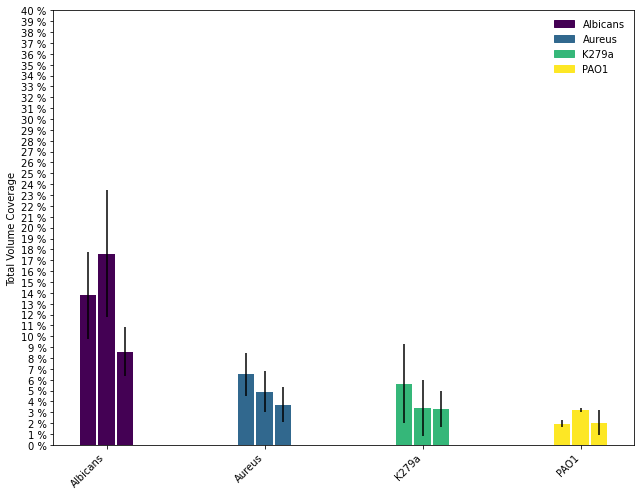

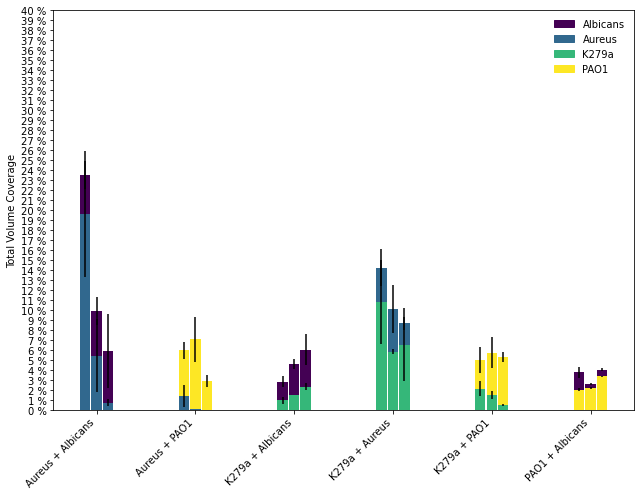

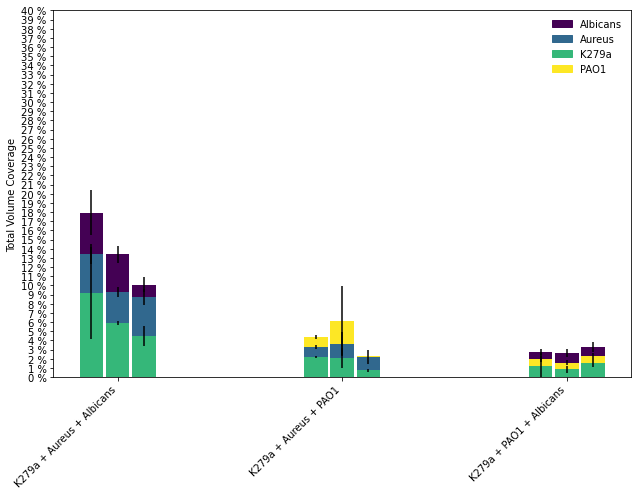

In [24]:
# Parameters
GERMS = ['Albicans', 'Aureus', 'K279a', 'PAO1']
cmap = cm.get_cmap('viridis', len(GERMS))
colors = {germ: cmap(key)[:3] for key, germ in enumerate(GERMS)}
width = 0.35

for n_germs in [1, 2, 3]:
    # Data
    df_plot = df_tot_vol_stat.loc[df_tot_vol_stat['#germs'] == n_germs]
    films = np.unique(df_plot['biofilm'])
    germs = np.array([biofilm.split('+') for biofilm in films])
    germs = np.array([[germ.replace('pa01', 'pao1').strip() for germ in group] for group in germs])
        
    fig, ax = plt.subplots(figsize=(9, 7))

    for n, biofilm in enumerate(films):
        for t, time in enumerate(HOURS_POST_INFECTION):
            bottom = 0
            for g, germ in enumerate(germs[n]):
                means = df_plot.loc[(df_plot['biofilm'] == biofilm) & (df_plot['time'] == time), (f'volume {g + 1}', 'mean')]
                errs = df_plot.loc[(df_plot['biofilm'] == biofilm) & (df_plot['time'] == time), (f'volume {g + 1}', 'std')]
                rects = ax.bar(n - width / 3 + t * width / 3, means, width / 3 * 0.9, yerr=errs, color=colors[germ], bottom=bottom)
                bottom += means

    plt.legend(frameon=False, handles=[mpatches.Patch(color=val, label=key) for key, val in colors.items()])
    plt.xticks(range(len(films)), films, rotation=45, ha='right')
    plt.ylim([0, 11])
    yticks = np.arange(0, 41, step=1)
    plt.yticks(yticks, [f'{val:.0f} %' for val in yticks])
    plt.ylabel('Total Volume Coverage')
    plt.tight_layout()
    plt.savefig(RESULT_FOLDER / f"total_volumes_{n_germs}_species_film.jpg")
    plt.show()

In [25]:
films = df.index.unique().to_list()
max_z = np.median([biofilm.image_shape[1] * biofilm.voxel_sizes[2] for biofilm in biofilms])

In [26]:
film = films[3]
print(film)
biofilm_samples = [biofilm for biofilm in biofilms if biofilm.name==film]

K279a + Albicans


In [27]:
for t, hours_post_infection in enumerate(HOURS_POST_INFECTION):
    bfs = [biofilm for biofilm in biofilm_samples if biofilm.growth_duration==hours_post_infection]
    print(hours_post_infection)
    for bf in bfs:
        print(bf.name, bf.growth_duration, bf.voxel_sizes[2])

24h
K279a + Albicans 24h 4.399999999999999e-07
K279a + Albicans 24h 4.399999999999999e-07
K279a + Albicans 24h 4.399999999999999e-07
48h
K279a + Albicans 48h 4.399999999999999e-07
K279a + Albicans 48h 4.399999999999999e-07
K279a + Albicans 48h 4.399999999999999e-07
72h
K279a + Albicans 72h 5.2e-07
K279a + Albicans 72h 5.2e-07
K279a + Albicans 72h 5.2e-07


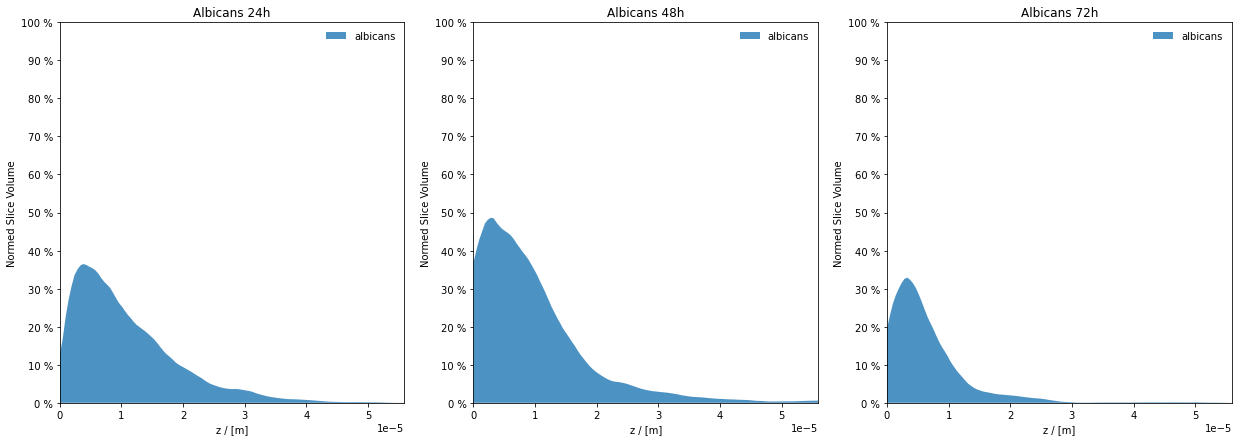

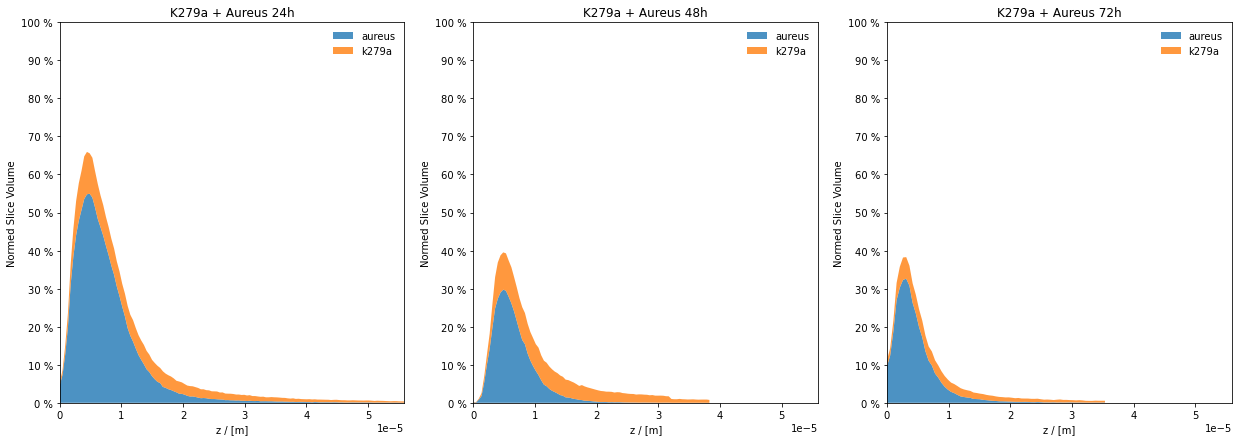

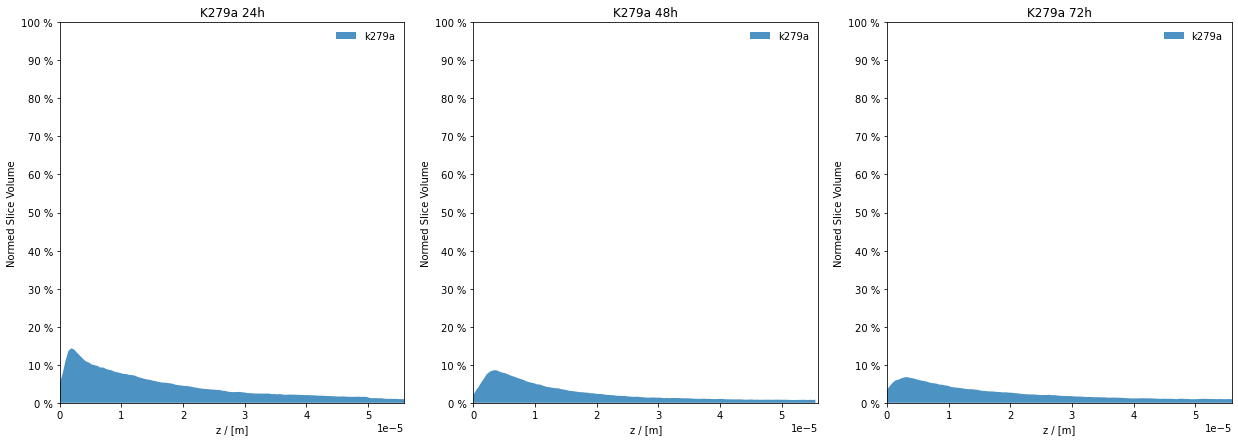

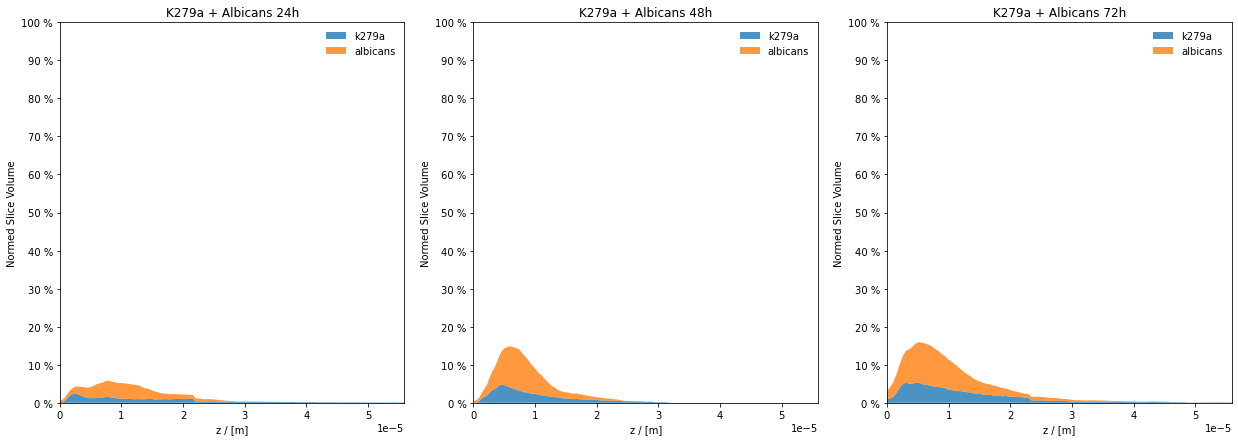

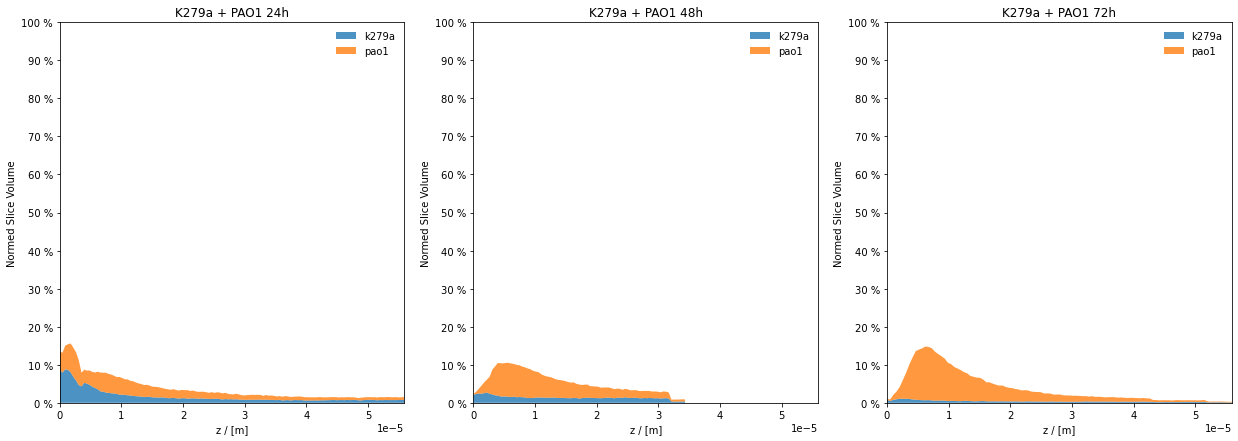

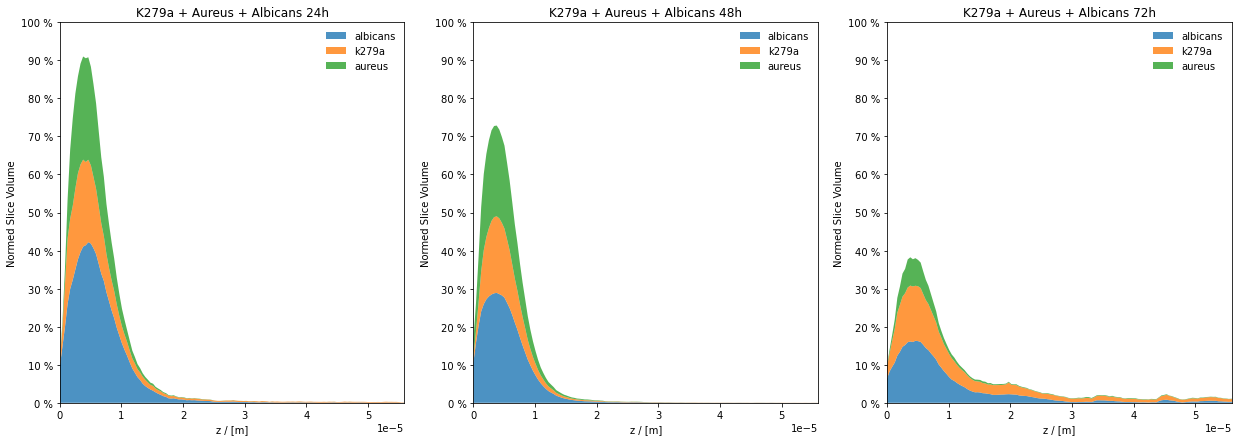

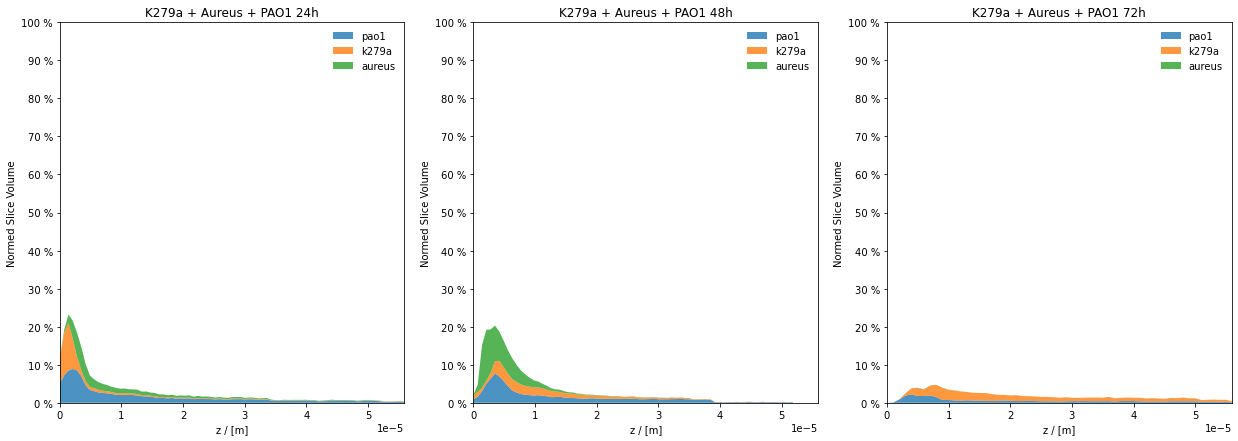

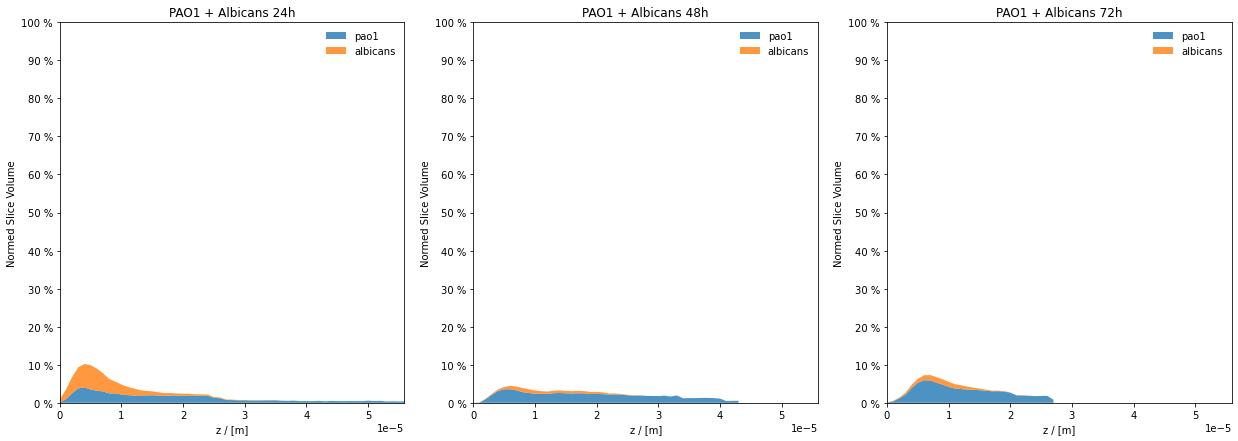

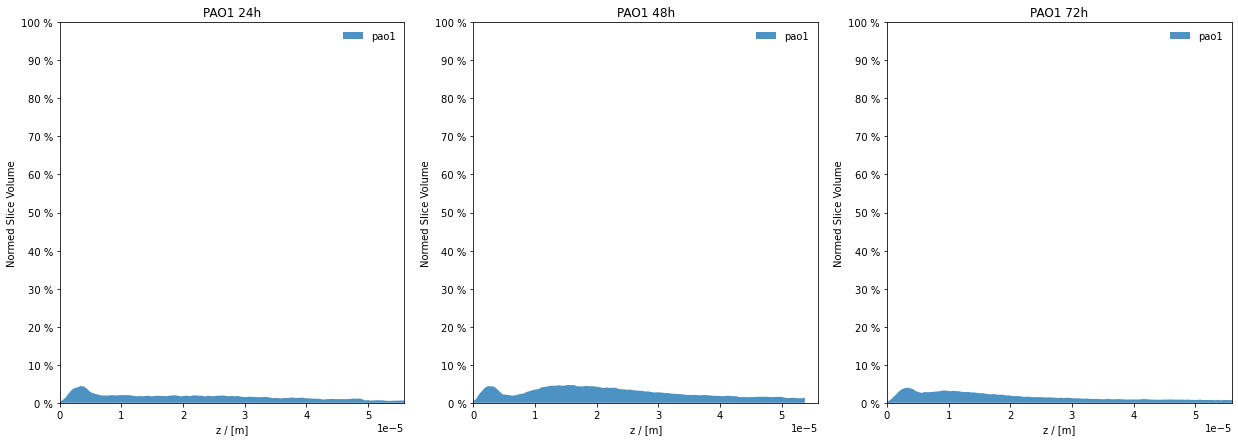

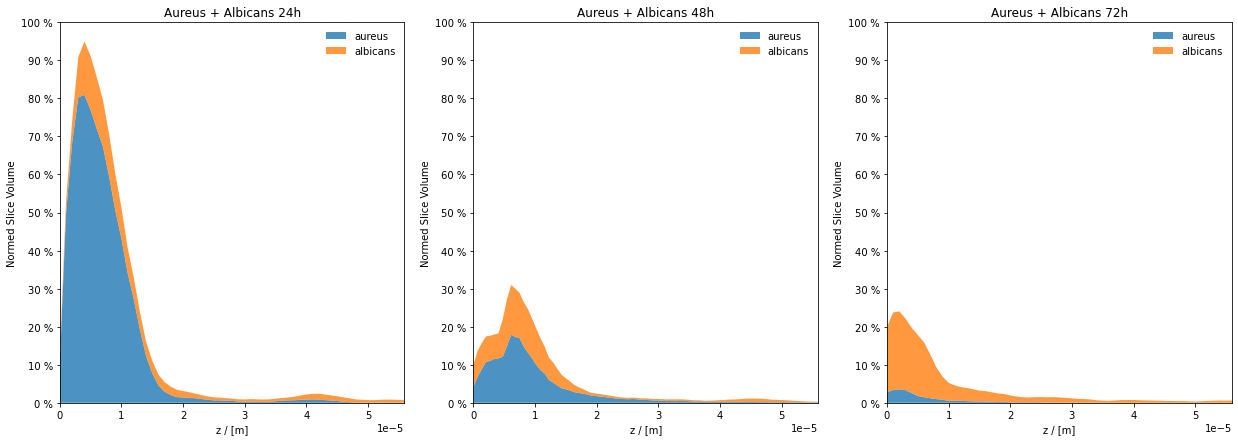

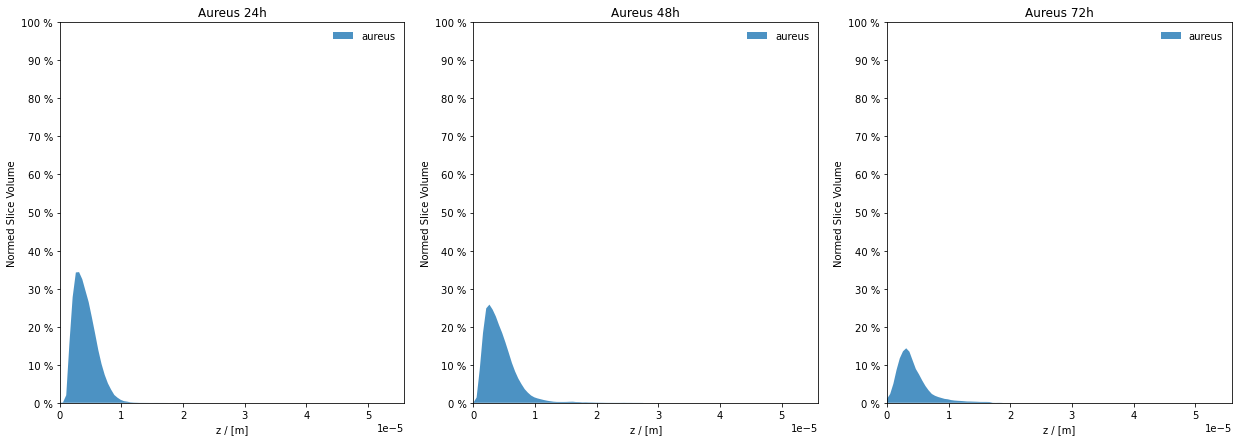

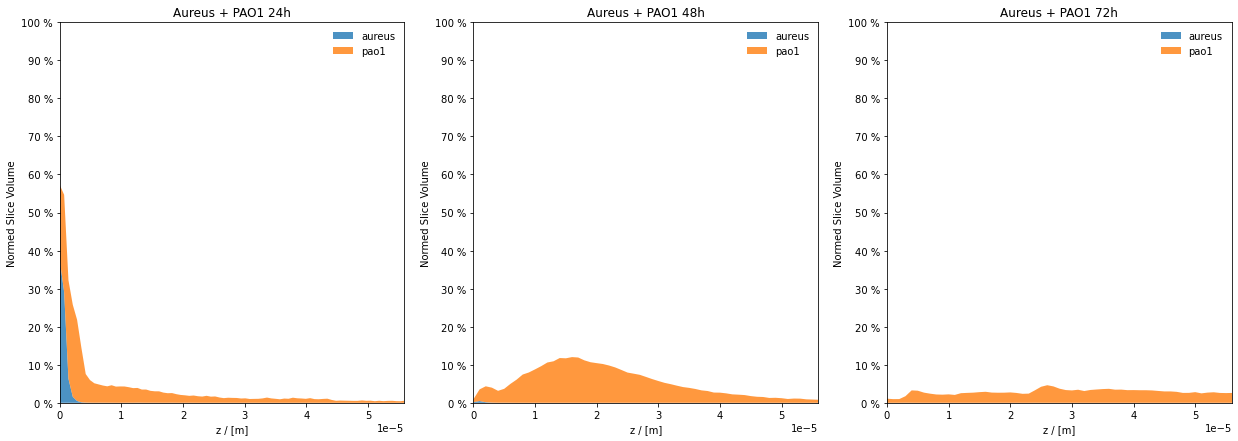

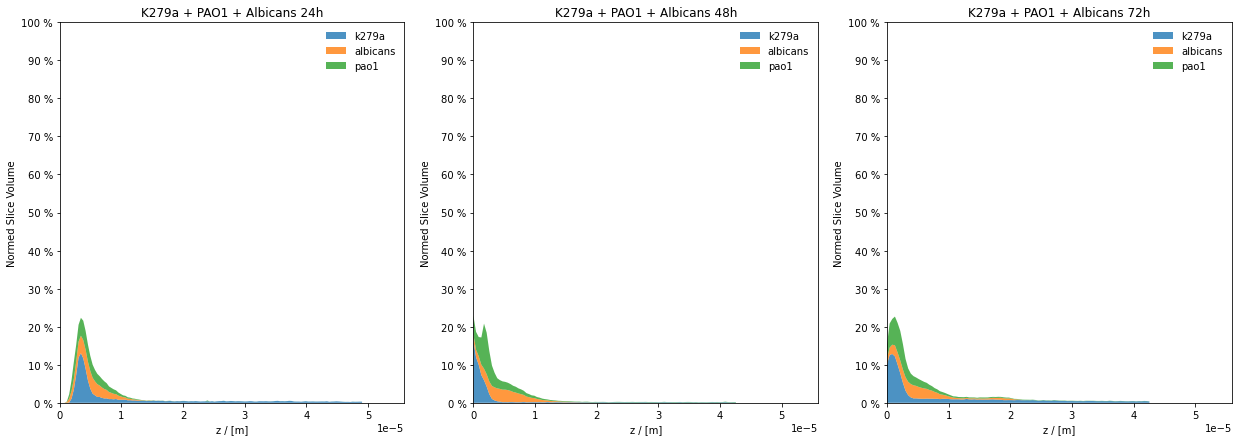

In [37]:
films = df.index.unique().to_list()
max_z = np.median([biofilm.image_shape[1] * biofilm.voxel_sizes[2] for biofilm in biofilms])
for f, film in enumerate(films[:]):
    biofilm_samples = [biofilm for biofilm in biofilms if biofilm.name==film]
    populations = {}

    nrows = 1
    ncols = 3
    plt.figure(figsize=(21, 7))
    
    for t, hours_post_infection in enumerate(HOURS_POST_INFECTION):
        bfs = [biofilm for biofilm in biofilm_samples if biofilm.growth_duration==hours_post_infection]
        max_slices = np.max([biofilm.image_shape[1] for biofilm in bfs])
        populations[t] = {}
        for g, germ in enumerate(biofilm_samples[0].germs):
            ys = np.zeros((len(bfs), max_slices))
            for m, bf in enumerate(bfs):
                total_slice_volume = np.prod(bf.image_shape[2:]) * np.prod(bf.voxel_sizes)
                ys[m, :len(bf.slice_volumes[g])] = bf.slice_volumes[g] / total_slice_volume
            x = np.arange(max_slices) * bfs[0].voxel_sizes[2]
            y_mean, y_std = np.mean(ys, axis=0), np.std(ys, axis=0)
            if film == 'K279a + Aureus + Albicans' and hours_post_infection == '48h':
                y_mean *= 0.425
            populations[t][germ] = y_mean

        plt.subplot(nrows, ncols, t + 1)
        plt.title(f"{film} {hours_post_infection}")
        plt.stackplot(x, populations[t].values(), labels=populations[t].keys(), baseline='zero', alpha=0.8)
        plt.ylim([0, 0.5])
        plt.xlim([0, max_z])
        yticks = np.arange(0, 1.01, step=0.1)
        plt.yticks(yticks, [f'{val * 100:.0f} %' for val in yticks])
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        plt.ylabel('Normed Slice Volume')
        plt.xlabel('z / [m]')
        plt.legend(frameon=False)
    plt.savefig(RESULT_FOLDER / f"{film}_{hours_post_infection}.jpg")
    plt.show()

            